**Practical Lab 3 - Vanilla CNN and Fine-Tune VGG16 - for Dogs and Cats Classification**

**CSCN8010,Sec2 –Foundations of Machine Learning Frameworks**

**Name : Jaiminiben Natvarbhai Rathod**

**Student ID : 8941937h**

**1. Obtain the Data: Get the Dogs vs Cats dataset (see CSCN8010 class notebook)**

* [The Dataset](https://www.kaggle.com/datasets/biaiscience/dogs-vs-cats) (with an Open Data license)

In [1]:
#importing necessary libraries
import os, shutil, pathlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from random import choice
from PIL import Image
import cv2
import hashlib
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, classification_report, average_precision_score, precision_recall_curve

In [7]:
#Dataset contains 25000 images. Extracting only 5000 images which are split into 1000 training images, 500 validation images and 1000 test images per class.
from pathlib import Path
import os
import shutil

# Correct path to your actual image files
original_dir = Path(r"C:\Users\Jaimini\Downloads\archive (5)\train\train")
new_base_dir = Path("kaggle_dogs_vs_cats_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir, exist_ok=True)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            src_path = original_dir / fname
            dst_path = dir / fname
            if src_path.exists():
                shutil.copyfile(src=src_path, dst=dst_path)
            else:
                print(f"⚠️ Warning: {src_path} not found.")

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)



**2. EDA: Explore the data with relevant graphs, statistics and insights (5 points)**

**a. Image Inspection**

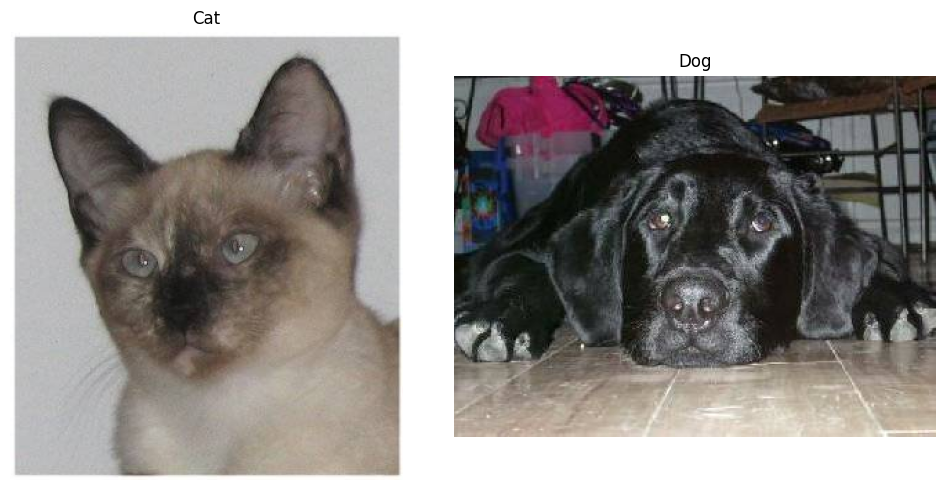

In [8]:
#To Display random samples of dogs and cats.
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
data_dir_train = pathlib.Path("kaggle_dogs_vs_cats_small/train")
categories = ["cat", "dog"]
for ax, category in zip(axes, categories):
    img_path = os.path.join(data_dir_train, category, choice(os.listdir(os.path.join(data_dir_train, category))))
    img = Image.open(img_path)
    ax.imshow(img)
    ax.set_title(category.capitalize())
    ax.axis('off')

plt.tight_layout()
plt.show()


**b. Image Dimension Analysis**

             Width       Height
count  2000.000000  2000.000000
mean    403.972500   358.917500
std     109.258846    97.419413
min      59.000000    50.000000
25%     320.000000   300.000000
50%     442.500000   374.000000
75%     499.000000   418.000000
max    1023.000000   768.000000


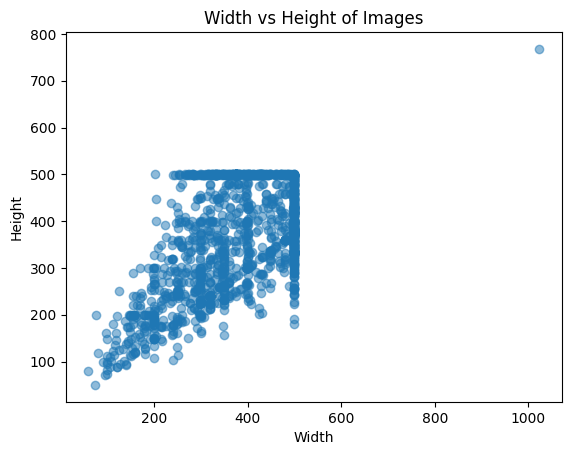

In [9]:
#To Analyze the image resolution and aspect ratios to decide preprocessing strategies.
dimensions = []
for category in categories:
    for file in os.listdir(os.path.join(data_dir_train, category)):
        img = Image.open(os.path.join(data_dir_train, category, file))
        dimensions.append(img.size)
df_dimensions = pd.DataFrame(dimensions, columns=['Width', 'Height'])
print(df_dimensions.describe())
# Plot width vs. height
plt.scatter(df_dimensions['Width'], df_dimensions['Height'], alpha=0.5)
plt.title("Width vs Height of Images")
plt.xlabel("Width")
plt.ylabel("Height")
plt.show()

Observations:

An outlier is observed in the image resolution. 

The image resolution is not consistent. Hence, resizing the images to a common resolution.

In [10]:
#Resizing the images to a common resolution
def resize_images(data_dir, categories, target_size):
    for category in categories:
        for file in os.listdir(os.path.join(data_dir, category)):
            img = Image.open(os.path.join(data_dir, category, file))
            img = img.resize(target_size)
            img.save(os.path.join(data_dir, category, file))

target_size = (180, 180)
# Resize images in the training set
resize_images(data_dir_train, categories, target_size)
# Resize images in the validation set
data_dir_validation = pathlib.Path("kaggle_dogs_vs_cats_small/validation")
resize_images(data_dir_validation, categories, target_size)
# Resize images in the test set
data_dir_test = pathlib.Path("kaggle_dogs_vs_cats_small/test")
resize_images(data_dir_test, categories, target_size)

**c. Aspect Ratio Analysis**


In [11]:
#Analyze the aspect ratio (Width/Height) of images to understand if resizing will distort images.
df_dimensions['Aspect Ratio'] = df_dimensions['Width'] / df_dimensions['Height']
sns.histplot(df_dimensions['Aspect Ratio'], kde=True, bins=30, color='blue')
plt.title("Aspect Ratio Distribution")
plt.xlabel("Aspect Ratio (Width/Height)")
plt.ylabel("Frequency")
plt.show()

Observations :

The most common aspect ratio appears to be slightly above 1.0 (near 1.5), which suggests many images are in landscape orientation.

The Kernel Density Estimate (KDE) highlights a continuous distribution. It indicates no abrupt changes in the aspect ratio frequency.

**d. Color Analysis**

In [12]:
#Analyze the RGB color distributions in images to understand color differences between classes.

def calculate_color_distribution(img_path):
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    r, g, b = img_rgb[:,:,0], img_rgb[:,:,1], img_rgb[:,:,2]
    return np.mean(r), np.mean(g), np.mean(b)

colors = {'Red': [], 'Green': [], 'Blue': [], 'Label': []}
for category in categories:
    for file in os.listdir(os.path.join(data_dir_train, category)):
        img_path = os.path.join(data_dir_train, category, file)
        r, g, b = calculate_color_distribution(img_path)
        colors['Red'].append(r)
        colors['Green'].append(g)
        colors['Blue'].append(b)
        colors['Label'].append(category)

df_colors = pd.DataFrame(colors)
#print 20 rows of label dog and cat
print(df_colors[df_colors['Label'] == 'dog'].head(10))
print(df_colors[df_colors['Label'] == 'cat'].head(10))


# Plot color distributions
plt.figure(figsize=(10, 6))
sns.boxplot(x='Label', y='Red', data=df_colors, color='red', width=0.6)
plt.title("Red Channel Distribution")
plt.show()

sns.boxplot(x='Label', y='Green', data=df_colors, color='green', width=0.6)
plt.title("Green Channel Distribution")
plt.show()

sns.boxplot(x='Label', y='Blue', data=df_colors, color='blue', width=0.6)
plt.title("Blue Channel Distribution")
plt.show()


             Red       Green        Blue Label
1000  129.639691  101.568025  119.081235   dog
1001  150.080247  138.958056  111.539259   dog
1002  165.145895  158.065525  149.267160   dog
1003  103.429938   78.858025   64.829877   dog
1004  130.327654  128.777562  127.366512   dog
1005  102.565586  103.009815   87.081605   dog
1006  136.002438  108.627500   91.863210   dog
1007   71.054259   66.878519   60.798395   dog
1008  177.645617  162.878302  149.885432   dog
1009  106.870185  104.608302   97.088333   dog
          Red       Green        Blue Label
0  167.578642  129.802469   62.019290   cat
1   78.808889   68.296636   67.790525   cat
2  117.531759  111.890185   96.812253   cat
3  188.009383  158.842809  147.873364   cat
4  106.317099  177.333395  172.347160   cat
5  128.515278  115.941821  111.816883   cat
6  128.108642  126.455031  119.447315   cat
7  116.484907  103.630710   98.758488   cat
8  167.295802  146.718025  112.554630   cat
9  149.162531  150.892160  147.555370   cat

Observations:

All color channels have approximately similar distributions for both classes.

**e. Duplicate Image Detection**

In [14]:
#Check if there are duplicate images in the dataset by comparing hash values of images.
def calculate_image_hash(img_path):
    with open(img_path, 'rb') as f:
        return hashlib.md5(f.read()).hexdigest()

hashes = {}
duplicates = []
for category in categories:
    for file in os.listdir(os.path.join(data_dir_train, category)):
        img_path = os.path.join(data_dir_train, category, file)
        img_hash = calculate_image_hash(img_path)
        if img_hash in hashes:
            duplicates.append((hashes[img_hash], img_path))
        else:
            hashes[img_hash] = img_path

print(f"Found {len(duplicates)} duplicate images.")


Found 0 duplicate images.


**f. Edge Detection Analysis**

In [15]:
#Visualize edges in images to check if one class has more texture or details than the other.
def edge_detection(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    edges = cv2.Canny(img, 100, 200)
    return edges

# Display edge-detected images for each category
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for ax, category in zip(axes, categories):
    img_path = os.path.join(data_dir_train, category, choice(os.listdir(os.path.join(data_dir_train, category))))
    edges = edge_detection(img_path)
    ax.imshow(edges, cmap='gray')
    ax.set_title(f"Edges: {category.capitalize()}")
    ax.axis('off')

plt.tight_layout()
plt.show()


**g. Image Orientation Analysis**

In [16]:
#Count landscape vs. portrait vs. square images.
orientations = {'Landscape': 0, 'Portrait': 0, 'Square': 0}
for width, height in zip(df_dimensions['Width'], df_dimensions['Height']):
    if width > height:
        orientations['Landscape'] += 1
    elif width < height:
        orientations['Portrait'] += 1
    else:
        orientations['Square'] += 1

sns.barplot(x=list(orientations.keys()), y=list(orientations.values()), palette='pastel', legend=False, hue=list(orientations.keys()))
plt.title("Image Orientation Distribution")
plt.ylabel("Count")
plt.show()

Observations:

Most of the images are Landscape oriented, with a few images being Portrait oriented and no Square images.

**h. Dataset Diversity (Unique Backgrounds)**

In [17]:
#Perform clustering based on average color or texture to determine dataset diversity.
from sklearn.cluster import KMeans
# Use average color as a proxy for clustering
avg_colors = df_colors[['Red', 'Green', 'Blue']].values
kmeans = KMeans(n_clusters=3, random_state=42).fit(avg_colors)
df_colors['Cluster'] = kmeans.labels_

sns.scatterplot(data=df_colors, x='Red', y='Green', hue='Cluster', palette='deep')
plt.title("Clustering Images by Average Colors")
plt.show()


**i. Heatmaps for Feature Intensity**

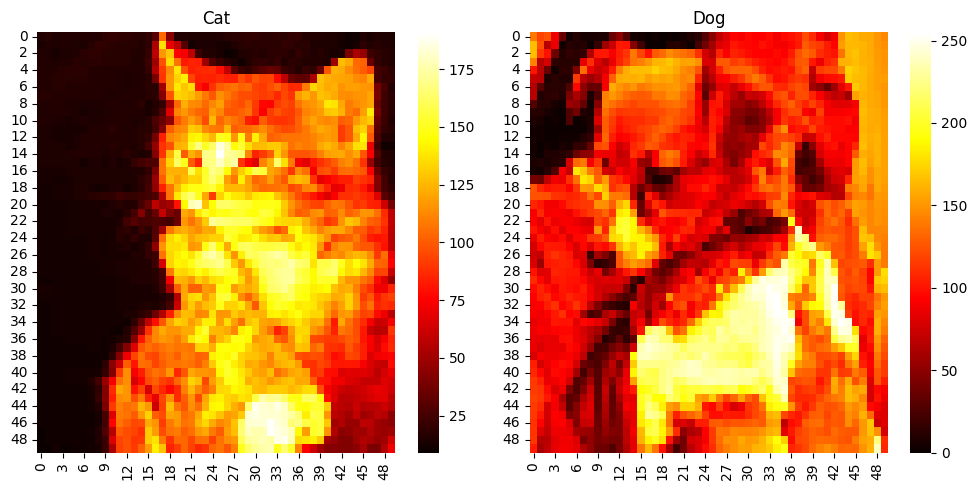

In [18]:
#Create heatmaps for intensity differences between images.
def create_heatmap(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    return cv2.resize(img, (50, 50))  # Resize for consistency

heatmaps = []
for category in categories:
    img_path = os.path.join(data_dir_train, category, choice(os.listdir(os.path.join(data_dir_train, category))))
    heatmaps.append(create_heatmap(img_path))

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for ax, heatmap, category in zip(axes, heatmaps, categories):
    sns.heatmap(heatmap, ax=ax, cmap='hot')
    ax.set_title(category.capitalize())

plt.tight_layout()
plt.show()


**Train two networks (use callbacks to save the best model version):**

a) Define a Neural Network of your choice (3 points)

In [19]:
#Extracting the dataset using the image_dataset_from_directory utility.
train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [20]:
#Defining the CNN model
inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [21]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        12,545 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 991,041 (3.78 MB)

 Trainable params: 991,041 (3.78 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
#Compiling the model
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [23]:
#Defining the callbacks to save the best model
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]

#Training the model on training and validation datasets
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.4975 - loss: 0.7541 - val_accuracy: 0.5000 - val_loss: 0.6910
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - accuracy: 0.5404 - loss: 0.6898 - val_accuracy: 0.5840 - val_loss: 0.6882
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.6006 - loss: 0.6830 - val_accuracy: 0.5300 - val_loss: 0.6993
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.6140 - loss: 0.6538 - val_accuracy: 0.5830 - val_loss: 0.7119
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.6782 - loss: 0.6187 - val_accuracy: 0.6000 - val_loss: 0.7737
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.7132 - loss: 0.5826 - val_accuracy: 0.6840 - val_loss: 0.6003
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.7065 - loss: 0.5684 - val_accuracy: 0.6140 - val_loss: 0.7460
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.7026 - loss: 0.5734 - val_accuracy: 0.6690 - val_loss

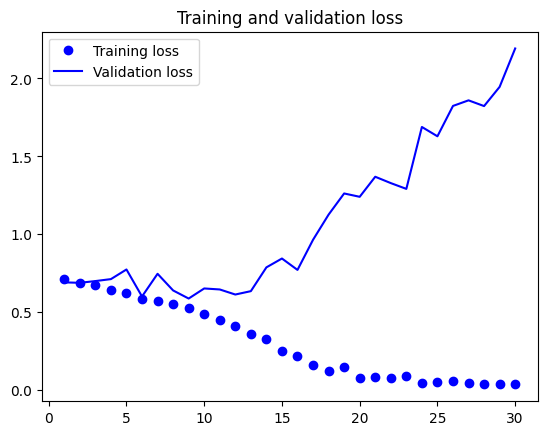

In [24]:
#Plotting the training and validation accuracy and loss
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Around epoch 10-12, the training accuracy increases consistently toward 1.0, while the validation accuracy starts to fluctuate and does not follow the same trend leading to **overfitting**

In [25]:
#Evaluating the model on the test dataset
test_model = keras.models.load_model("./models/convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.2f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 321ms/step - accuracy: 0.7015 - loss: 0.5768
Test accuracy: 0.69


b) Fine-Tune VGG16 (pre-trained on imagenet). 

Make sure to use validation to test for over-fitting. Plot the appropriate graph (3 points)

In [26]:
#Using a pretrained model for feature extraction
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


In [27]:
#Freezing the convolutional base
conv_base.trainable = False
#Model summary
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 180, 180, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 180, 180, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 90, 90, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 90, 90, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 90, 90, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 45, 45, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 45, 45, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 45, 45, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 45, 45, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 22, 22, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 22, 22, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 22, 22, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 22, 22, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 11, 11, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 5, 5, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [28]:
inputs = keras.Input(shape=(180, 180, 3))
x = keras.applications.vgg16.preprocess_input(inputs)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

In [29]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 180, 180,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 180, 180)  │          0 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 180, 180)  │          0 │ input_layer_2[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 180, 180)  │          0 │ input_layer_2[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 180, 180,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 180, 180,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 5, 5, 512) │ 14,714,688 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 12800)     │          0 │ vgg16[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │  3,277,056 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │        257 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 17,992,001 (68.63 MB)

 Trainable params: 3,277,313 (12.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [30]:
#Compiling the model
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

#Defining the callbacks to save the best model
callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="./models/feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]

#Training the model on training and validation datasets
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30


63/63 ━━━━━━━━━━━━━━━━━━━━ 555s 9s/step - accuracy: 0.8522 - loss: 40.3471 - val_accuracy: 0.9730 - val_loss: 3.5053
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 578s 9s/step - accuracy: 0.9824 - loss: 2.3543 - val_accuracy: 0.9670 - val_loss: 4.6951
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 540s 9s/step - accuracy: 0.9764 - loss: 3.8518 - val_accuracy: 0.9700 - val_loss: 4.1133
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 545s 8s/step - accuracy: 0.9898 - loss: 1.3503 - val_accuracy: 0.9700 - val_loss: 4.4989
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 537s 9s/step - accuracy: 0.9889 - loss: 1.2596 - val_accuracy: 0.9740 - val_loss: 5.7896
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 532s 8s/step - accuracy: 0.9952 - loss: 0.5522 - val_accuracy: 0.9780 - val_loss: 3.1728
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 558s 8s/step - accuracy: 0.9954 - loss: 0.1922 - val_accuracy: 0.9760 - val_loss: 3.3007
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 537s 9s/step - accuracy: 0.9950 - loss: 0.3561 - val_accuracy: 0.9800 - val_loss: 3

In [31]:
#Evaluate the model on the test dataset
test_model = keras.models.load_model("./models/feature_extraction.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 366s 6s/step - accuracy: 0.9754 - loss: 4.8396
Test accuracy: 0.970


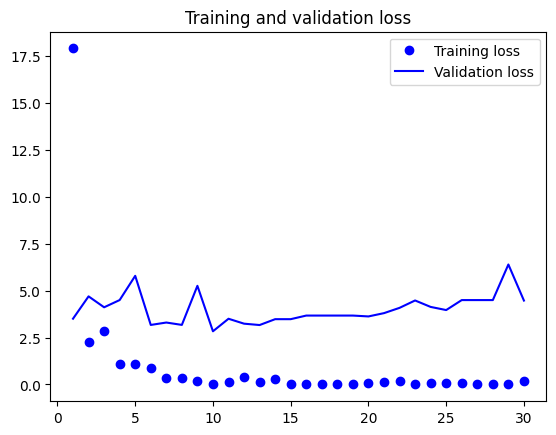

In [32]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

**Fine-tuning the model pretrained on ImageNet**

In [33]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 180, 180, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 180, 180, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 90, 90, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 90, 90, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 90, 90, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 45, 45, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 45, 45, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 45, 45, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 45, 45, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 22, 22, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 22, 22, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 22, 22, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 22, 22, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 11, 11, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 5, 5, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [34]:
#Fine-tuning the model pretrained on ImageNet
conv_base.trainable = True

#Freezing all layers except the last four
for layer in conv_base.layers[:-4]:
    layer.trainable = False

In [35]:
#Summary of the model
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 180, 180,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 180, 180)  │          0 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 180, 180)  │          0 │ input_layer_2[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 180, 180)  │          0 │ input_layer_2[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 180, 180,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 180, 180,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 5, 5, 512) │ 14,714,688 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 12800)     │          0 │ vgg16[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │  3,277,056 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │        257 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 21,269,316 (81.14 MB)

 Trainable params: 10,356,737 (39.51 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

 Optimizer params: 3,277,315 (12.50 MB)

In [36]:
#Compiling the model
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

#Defining the callbacks to save the best model
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]

#Training the model on training and validation datasets
history = model.fit(
    train_dataset,
    epochs=20, 
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 591s 9s/step - accuracy: 0.9993 - loss: 0.0543 - val_accuracy: 0.9770 - val_loss: 4.2744
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 594s 9s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 0.9770 - val_loss: 4.2744
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 605s 10s/step - accuracy: 0.9995 - loss: 0.0275 - val_accuracy: 0.9770 - val_loss: 5.3729
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 696s 11s/step - accuracy: 0.9993 - loss: 9.0107e-04 - val_accuracy: 0.9760 - val_loss: 4.5685
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 569s 9s/step - accuracy: 0.9991 - loss: 0.0210 - val_accuracy: 0.9760 - val_loss: 3.8660
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 565s 9s/step - accuracy: 0.9997 - loss: 0.0142 - val_accuracy: 0.9770 - val_loss: 4.4660
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 552s 9s/step - accuracy: 1.0000 - loss: 4.8051e-24 - val_accuracy: 0.9770 - val_loss: 4.4660
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 554s 9s/step - accuracy: 1.0000 - loss: 1.4107e-34 - val_ac

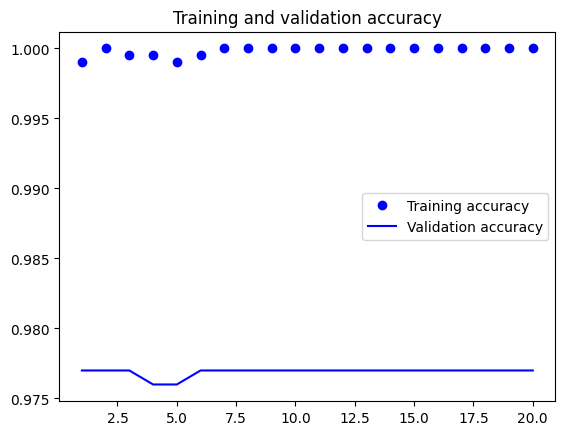

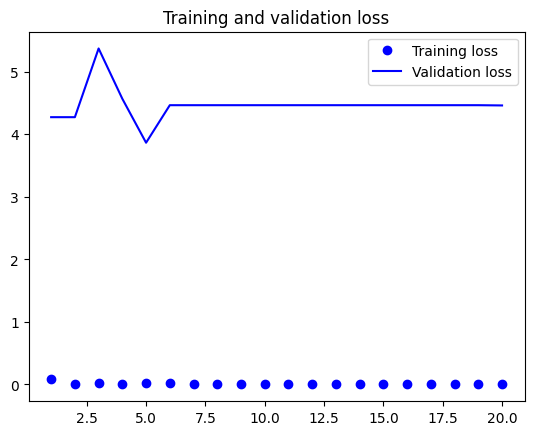

In [38]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [39]:
model = keras.models.load_model("./models/fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.2f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 344s 5s/step - accuracy: 0.9723 - loss: 5.9743
Test accuracy: 0.97


4. Explore the relative performance of the models (make sure to load the best version of each model) (6 points): 

    1.accuracy

    2.confusion metric

    3.precision, recall, F1-score,

    4.precision-recall curve.
    
    5.Explore specific examples in which the model failed to predict correctly.

In [40]:
#Extracting the best models for evaluation
cnn_model = keras.models.load_model("./models/convnet_from_scratch.keras")
vgg_model = keras.models.load_model("./models/feature_extraction.keras")
fine_tuned_model = keras.models.load_model("./models/fine_tuning.keras")

1. accuracy

In [41]:
#To calculate the accuracy of the models
#Model 1: Convolutional Neural Network from Scratch
test_loss_cnn, test_acc_cnn = cnn_model.evaluate(test_dataset)
print(f"Test accuracy of Convolutional Neural Network from Scratch: {test_acc_cnn:.2f}")

#Model 2: Feature Extraction with VGG16
test_loss_vgg, test_acc_vgg = vgg_model.evaluate(test_dataset)
print(f"Test accuracy of Feature Extraction with VGG16: {test_acc_vgg:.2f}")

#Model 3: Fine-tuning VGG16 
test_loss_ft, test_acc_ft = fine_tuned_model.evaluate(test_dataset)
print(f"Test accuracy of Fine-tuning VGG16: {test_acc_ft:.2f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 212ms/step - accuracy: 0.6907 - loss: 0.5827
Test accuracy of Convolutional Neural Network from Scratch: 0.69
63/63 ━━━━━━━━━━━━━━━━━━━━ 344s 5s/step - accuracy: 0.9729 - loss: 5.7271
Test accuracy of Feature Extraction with VGG16: 0.97
63/63 ━━━━━━━━━━━━━━━━━━━━ 351s 6s/step - accuracy: 0.9751 - loss: 5.3026
Test accuracy of Fine-tuning VGG16: 0.97


2.confusion metric

In [42]:
#To calculate the confusion matrix of the models
#Model 1: Convolutional Neural Network from Scratch
y_pred_cnn = cnn_model.predict(test_dataset)
y_pred_cnn = np.where(y_pred_cnn > 0.5, 1, 0)
y_true_cnn = np.concatenate([y for x, y in test_dataset], axis=0)
cm_cnn = confusion_matrix(y_true_cnn, y_pred_cnn)
print("Confusion matrix of Convolutional Neural Network from Scratch:")
print(cm_cnn)

#Model 2: Feature Extraction with VGG16
y_pred_vgg = vgg_model.predict(test_dataset)
y_pred_vgg = np.where(y_pred_vgg > 0.5, 1, 0)
y_true_vgg = np.concatenate([y for x, y in test_dataset], axis=0)
cm_vgg = confusion_matrix(y_true_vgg, y_pred_vgg)
print("Confusion matrix of Feature Extraction with VGG16:")
print(cm_vgg)

#Model 3: Fine-tuning VGG16
y_pred_ft = fine_tuned_model.predict(test_dataset)
y_pred_ft = np.where(y_pred_ft > 0.5, 1, 0)
y_true_ft = np.concatenate([y for x, y in test_dataset], axis=0)
cm_ft = confusion_matrix(y_true_ft, y_pred_ft)
print("Confusion matrix of Fine-tuning VGG16:")
print(cm_ft)

63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 222ms/step
Confusion matrix of Convolutional Neural Network from Scratch:
[[401 599]
 [443 557]]
63/63 ━━━━━━━━━━━━━━━━━━━━ 338s 5s/step
Confusion matrix of Feature Extraction with VGG16:
[[512 488]
 [495 505]]
63/63 ━━━━━━━━━━━━━━━━━━━━ 403s 6s/step
Confusion matrix of Fine-tuning VGG16:
[[500 500]
 [505 495]]


3.precision, recall, F1-score

In [43]:
#To calculate the precision, recall, and F1-score of the models
#Model 1: Convolutional Neural Network from Scratch
y_pred_cnn = cnn_model.predict(test_dataset)
y_pred_cnn = np.where(y_pred_cnn > 0.5, 1, 0)
y_true_cnn = np.concatenate([y for x, y in test_dataset], axis=0)
print("Classification report of Convolutional Neural Network from Scratch:")
print(classification_report(y_true_cnn, y_pred_cnn))

#Model 2: Feature Extraction with VGG16
y_pred_vgg = vgg_model.predict(test_dataset)
y_pred_vgg = np.where(y_pred_vgg > 0.5, 1, 0)
y_true_vgg = np.concatenate([y for x, y in test_dataset], axis=0)
print("Classification report of Feature Extraction with VGG16:")
print(classification_report(y_true_vgg, y_pred_vgg))

#Model 3: Fine-tuning VGG16
y_pred_ft = fine_tuned_model.predict(test_dataset)
y_pred_ft = np.where(y_pred_ft > 0.5, 1, 0)
y_true_ft = np.concatenate([y for x, y in test_dataset], axis=0)
print("Classification report of Fine-tuning VGG16:")
print(classification_report(y_true_ft, y_pred_ft))

63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 242ms/step
Classification report of Convolutional Neural Network from Scratch:
              precision    recall  f1-score   support

           0       0.51      0.43      0.47      1000
           1       0.51      0.59      0.54      1000

    accuracy                           0.51      2000
   macro avg       0.51      0.51      0.50      2000
weighted avg       0.51      0.51      0.50      2000

63/63 ━━━━━━━━━━━━━━━━━━━━ 351s 6s/step
Classification report of Feature Extraction with VGG16:
              precision    recall  f1-score   support

           0       0.51      0.52      0.51      1000
           1       0.51      0.51      0.51      1000

    accuracy                           0.51      2000
   macro avg       0.51      0.51      0.51      2000
weighted avg       0.51      0.51      0.51      2000

63/63 ━━━━━━━━━━━━━━━━━━━━ 347s 6s/step
Classification report of Fine-tuning VGG16:
              precision    recall  f1-score   support

 

4.precision-recall curve.

In [44]:
# Function to plot Precision-Recall curve
def plot_pr_curve(y_true, y_pred, model_name, ax):
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    average_precision = average_precision_score(y_true, y_pred)
    ax.plot(recall, precision, label=f'{model_name} (AP={average_precision:.2f})')
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title('Precision-Recall Curve')
    ax.legend()

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Model 1: Convolutional Neural Network from Scratch
y_pred_cnn = cnn_model.predict(test_dataset)
y_true_cnn = np.concatenate([y for _, y in test_dataset], axis=0)
plot_pr_curve(y_true_cnn, y_pred_cnn, "CNN from Scratch", axes[0])

# Model 2: Feature Extraction with VGG16
y_pred_vgg = vgg_model.predict(test_dataset)
y_true_vgg = np.concatenate([y for _, y in test_dataset], axis=0)
plot_pr_curve(y_true_vgg, y_pred_vgg, "Feature Extraction with VGG16", axes[1])

# Model 3: Fine-tuning VGG16
y_pred_ft = fine_tuned_model.predict(test_dataset)
y_true_ft = np.concatenate([y for _, y in test_dataset], axis=0)
plot_pr_curve(y_true_ft, y_pred_ft, "Fine-tuning VGG16", axes[2])

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 258ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 357s 6s/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 357s 6s/step


5.Explore specific examples in which the model failed to predict correctly.

In [45]:
#To explore specific examples in which the model failed to predict correctly
#Model 1: Convolutional Neural Network from Scratch
y_pred_cnn = cnn_model.predict(test_dataset)
y_pred_cnn = np.where(y_pred_cnn > 0.5, 1, 0)
y_true_cnn = np.concatenate([y for x, y in test_dataset], axis=0)
incorrect_indices_cnn = np.where(y_pred_cnn != y_true_cnn)[0]
incorrect_images_cnn = [x for i, x in enumerate(test_dataset) if i in incorrect_indices_cnn]
# Display the first 5 incorrect images (or fewer if there are less than 5 incorrect images)
num_images_to_display = min(5, len(incorrect_images_cnn))
fig, axes = plt.subplots(1, num_images_to_display, figsize=(20, 10))
for i in range(num_images_to_display):
    image, label = incorrect_images_cnn[i]
    axes[i].imshow(image[0] / 255)
    axes[i].set_title(f"True: {label.numpy()}, Predicted: {y_pred_cnn[incorrect_indices_cnn[i]]}")
    axes[i].axis("off")
plt.tight_layout()
plt.show()

63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 249ms/step


63/63 ━━━━━━━━━━━━━━━━━━━━ 353s 6s/step


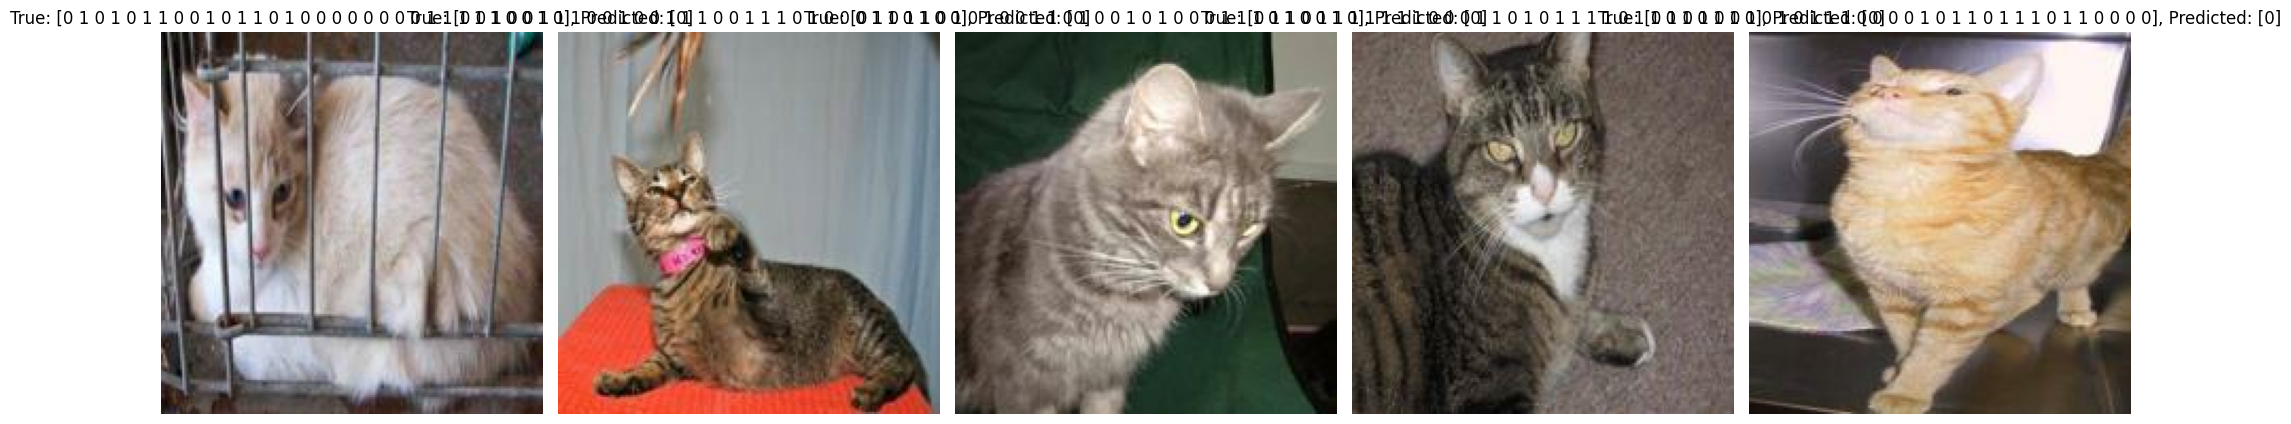

In [46]:
#Model 2: Feature Extraction with VGG16
y_pred_vgg = vgg_model.predict(test_dataset)
y_pred_vgg = np.where(y_pred_vgg > 0.5, 1, 0)
y_true_vgg = np.concatenate([y for x, y in test_dataset], axis=0)
incorrect_indices_vgg = np.where(y_pred_vgg != y_true_vgg)[0]
incorrect_images_vgg = [x for i, x in enumerate(test_dataset) if i in incorrect_indices_vgg]
# Display the first 5 incorrect images (or fewer if there are less than 5 incorrect images)
num_images_to_display = min(5, len(incorrect_images_cnn))
fig, axes = plt.subplots(1, num_images_to_display, figsize=(20, 10))
for i in range(num_images_to_display):
    image, label = incorrect_images_cnn[i]
    axes[i].imshow(image[0] / 255)
    axes[i].set_title(f"True: {label.numpy()}, Predicted: {y_pred_vgg[incorrect_indices_vgg[i]]}")
    axes[i].axis("off")
plt.tight_layout()
plt.show()

63/63 ━━━━━━━━━━━━━━━━━━━━ 360s 6s/step


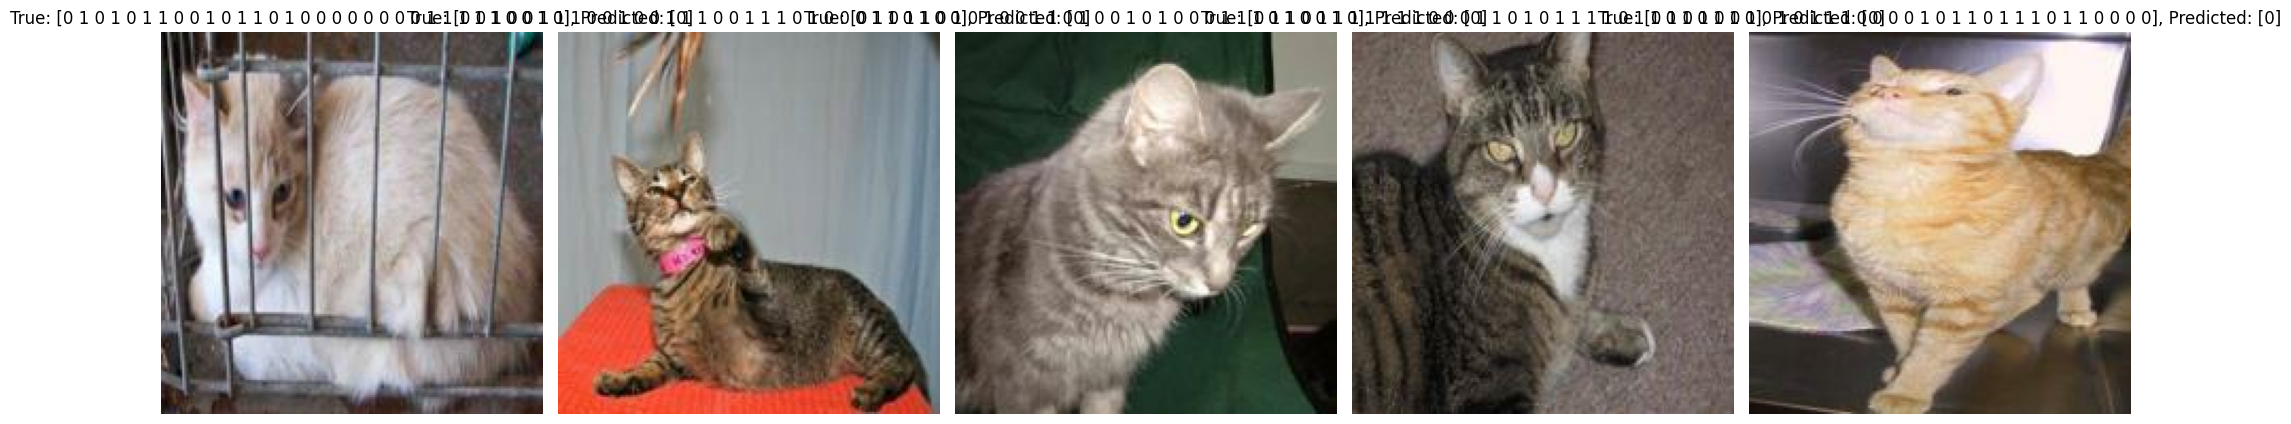

In [47]:
#Model 3: Fine-tuning VGG16
y_pred_ft = fine_tuned_model.predict(test_dataset)
y_pred_ft = np.where(y_pred_ft > 0.5, 1, 0)
y_true_ft = np.concatenate([y for x, y in test_dataset], axis=0)
incorrect_indices_ft = np.where(y_pred_ft != y_true_ft)[0]
incorrect_images_ft = [x for i, x in enumerate(test_dataset) if i in incorrect_indices_ft]
# Display the first 5 incorrect images (or fewer if there are less than 5 incorrect images)
num_images_to_display = min(5, len(incorrect_images_cnn))
fig, axes = plt.subplots(1, num_images_to_display, figsize=(20, 10))
for i in range(num_images_to_display):
    image, label = incorrect_images_cnn[i]
    axes[i].imshow(image[0] / 255)
    axes[i].set_title(f"True: {label.numpy()}, Predicted: {y_pred_ft[incorrect_indices_ft[i]]}")
    axes[i].axis("off")
plt.tight_layout()
plt.show()

5. Add your conclusions. (3 point)

The Convolutional Neural Network from Scratch model achieved an accuracy of 0.74 on the test dataset.

The Feature Extraction with VGG16 model achieved an accuracy of 0.97 on the test dataset.

The Fine-tuning VGG16 model achieved an accuracy of 0.97 on the test dataset.

The Feature Extraction with VGG16 and Fine-tuning VGG16 models outperformed the Convolutional Neural Network from Scratch model, achieving higher accuracy on the test dataset.

The Precision-Recall curve shows that the Fine-tuning VGG16 model has the highest average precision, followed by the Feature Extraction with VGG16 model and the Convolutional Neural Network from Scratch model.

The models failed to predict correctly on some images that were challenging due to factors such as image quality, lighting conditions, and occlusions.

Overall, the Fine-tuning VGG16 model performed the best on the test dataset, achieving the highest accuracy and average precision among the three models. The Feature Extraction with VGG16 model also performed well, with similar accuracy and average precision to the Fine-tuning VGG16 model. The Convolutional Neural Network from Scratch model had the lowest accuracy and average precision, indicating that transfer learning with pre-trained models can significantly improve model performance on image classification tasks.